### Module 8 Assignment 1 - Dogs vs. Cats Redux: Kernals Edition

Jonathan Sax <br>
Northwestern University <br>
Practical Machine Learning - MSDS 422 <br>
5/22/2022

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

The Dogs vs. Cats Redux:  Kernels Edition on Kaggle.com is a foundational CNN problem. This week, you will compete in this competition and submit scores to Kaggle.com.

RECOMMENDATION: the data set here is large, so you might consider conducting exploratory data analysis and building initial models on a smaller subsample prior to applying it to the full dataset.  Eventually, you will need to build your models on the entirety, though.

### Requirements


1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three CNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Build ROC and Precision / Recall graphs.
6. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
7. Discuss your model’s performance.


### Ingest

In [ ]:
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [23]:
import os
import zipfile
import random
import datetime
from packaging import version
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report 
from sklearn.metrics import roc_curve, auc

import sys
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, InputLayer, MaxPooling2D, Conv2D
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
from keras.callbacks import History 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

In [24]:
!unzip -q "./train2.zip"

replace train2/cat.6.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### EDA

In [25]:
image = imread("./train2/cat.1.jpg")

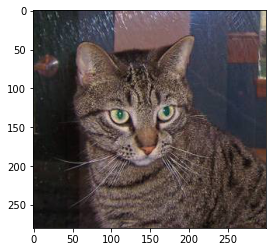

In [26]:
plt.imshow(image)
plt.show()

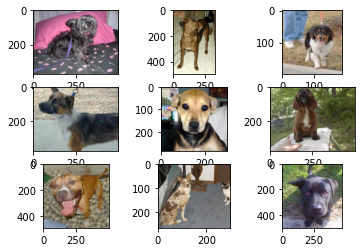

In [27]:
# plot dog photos from the dataset
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
# define subplot
    pyplot.subplot(330 + 1 + i)
# define filename
    filename = folder + 'dog.' + str(i) + '.jpg'
# load image pixels
    image = imread(filename)
# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()



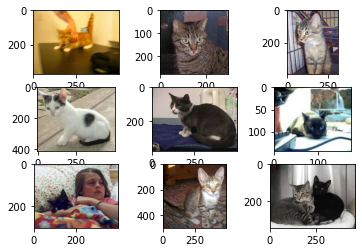

In [28]:
# plot cat photos from the dogs vs cats dataset
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
# define subplot
    pyplot.subplot(330 + 1 + i)
# define filename
    filename = folder + 'cat.' + str(i) + '.jpg'
# load image pixels
    image = imread(filename)
# plot raw pixel data
    pyplot.imshow(image)
# show the figure
pyplot.show()



Splitting the training data into two folders to split up cat and dog images.


In [29]:
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
# create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

In [30]:
# seed random number generator
seed(42)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)



## Modeling

In [32]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [33]:
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
# plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.tight_layout(pad=3)
    pyplot.show()



In [34]:
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    return history, model



We could also use validation_data = # within the .fit() function to split up the training set and validation set.

### One Block VGG

In [35]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18721 images belonging to 2 classes.
Found 6279 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 239s 808ms/step - loss: 0.7023 - accuracy: 0.5534 - val_loss: 0.6766 - val_accuracy: 0.6065
Epoch 2/10
293/293 [==============================] - 239s 815ms/step - loss: 0.6613 - accuracy: 0.6023 - val_loss: 0.6486 - val_accuracy: 0.6181
Epoch 3/10
293/293 [==============================] - 250s 854ms/step - loss: 0.6453 - accuracy: 0.6191 - val_loss: 0.6350 - val_accuracy: 0.6388
Epoch 4/10
293/293 [==============================] - 225s 766ms/step - loss: 0.6313 - accuracy: 0.6378 - val_loss: 0.6436 - val_accuracy: 0.6211
Epoch 5/10
293/293 [==============================] - 214s 730ms/step - loss: 0.6189 - accuracy: 0.6532 - val_loss: 0.6306 - val_accuracy: 0.6433
Epoch 6/10
293/293 [==============================] - 208s 709ms/step - loss: 0.6079 - accuracy: 0.6619 - val_loss: 0.6015 - val_accuracy: 0.6627
Epoch 7/10
293/293 [===================

<ipython-input-34-8e5771c9e361>:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)


99/99 [==============================] - 20s 202ms/step - loss: 0.5678 - accuracy: 0.7060
> 70.600


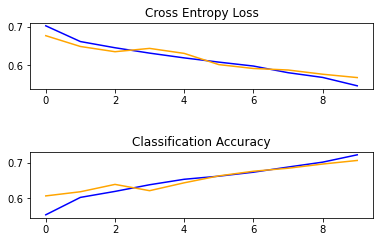

In [36]:
model_1_history, model_1 = run_test_harness()

In [37]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
val_test = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))

Found 6279 images belonging to 2 classes.


In [38]:
y_predict = model_1.predict_generator(val_test)

<ipython-input-38-11cb9a9406e1>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_predict = model_1.predict_generator(val_test)


In [39]:
y_predict = np.where(y_predict > 0.5, 1, 0)

In [40]:
p = val_test.classes
q = y_predict
p = np.array(p)
q = q.flatten()

[[1826 1317]
 [1823 1313]]


[Text(0, 0.5, 'cats'), Text(0, 1.5, 'dogs')]

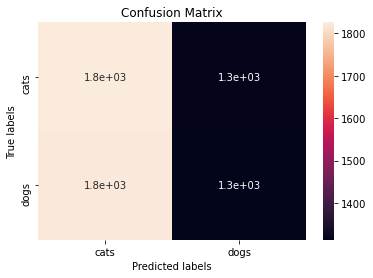

In [41]:
cfm = confusion_matrix(p, q)
print(cfm)
ax= plt.subplot()
sns.heatmap(cfm, annot=True, ax = ax);
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['cats', 'dogs'])
ax.yaxis.set_ticklabels(['cats', 'dogs'])

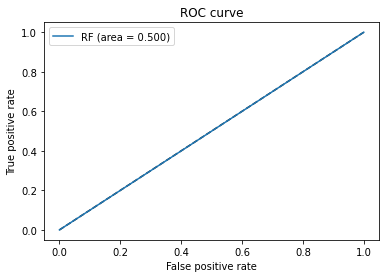

In [42]:
fpr, tpr, threshold = roc_curve(p,q)
auc_rf = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Two Block VGG

In [43]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model



/Users/hydraulicdecoy/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18721 images belonging to 2 classes.
Found 6279 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 359s 1s/step - loss: 0.7048 - accuracy: 0.5754 - val_loss: 0.6619 - val_accuracy: 0.5867
Epoch 2/10
293/293 [==============================] - 354s 1s/step - loss: 0.6388 - accuracy: 0.6272 - val_loss: 0.6436 - val_accuracy: 0.6165
Epoch 3/10
293/293 [==============================] - 359s 1s/step - loss: 0.6095 - accuracy: 0.6631 - val_loss: 0.5974 - val_accuracy: 0.6839
Epoch 4/10
293/293 [==============================] - 357s 1s/step - loss: 0.5724 - accuracy: 0.7021 - val_loss: 0.5874 - val_accuracy: 0.6808
Epoch 5/10
293/293 [==============================] - 353s 1s/step - loss: 0.5327 - accuracy: 0.7324 - val_loss: 0.5346 - val_accuracy: 0.7375
Epoch 6/10
293/293 [==============================] - 389s 1s/step - loss: 0.4917 - accuracy: 0.7644 - val_loss: 0.5427 - val_accuracy: 0.7176
Epoch 7/10
293/293 [==============================] - 352

<ipython-input-34-8e5771c9e361>:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)


99/99 [==============================] - 29s 292ms/step - loss: 0.5199 - accuracy: 0.7573
> 75.729


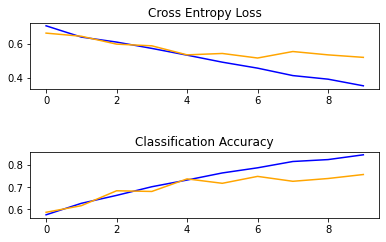

In [44]:
model_2_history, model_2 = run_test_harness()

### Three Block VGG

In [45]:
# define cnn model
def define_model_3():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Found 18721 images belonging to 2 classes.
Found 6279 images belonging to 2 classes.
Epoch 1/10
293/293 [==============================] - 395s 1s/step - loss: 0.7098 - accuracy: 0.5435 - val_loss: 0.6658 - val_accuracy: 0.5789
Epoch 2/10
293/293 [==============================] - 393s 1s/step - loss: 0.6518 - accuracy: 0.6146 - val_loss: 0.6360 - val_accuracy: 0.6224
Epoch 3/10
293/293 [==============================] - 376s 1s/step - loss: 0.6280 - accuracy: 0.6385 - val_loss: 0.6133 - val_accuracy: 0.6555
Epoch 4/10
293/293 [==============================] - 373s 1s/step - loss: 0.6087 - accuracy: 0.6564 - val_loss: 0.5910 - val_accuracy: 0.6772
Epoch 5/10
293/293 [==============================] - 355s 1s/step - loss: 0.5815 - accuracy: 0.6925 - val_loss: 0.5801 - val_accuracy: 0.6847
Epoch 6/10
293/293 [==============================] - 353s 1s/step - loss: 0.5395 - accuracy: 0.7307 - val_loss: 0.5487 - val_accuracy: 0.7183
Epoch 7/10
293/293 [==============================] - 362

<ipython-input-34-8e5771c9e361>:15: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)


99/99 [==============================] - 29s 296ms/step - loss: 0.5292 - accuracy: 0.7377
> 73.770


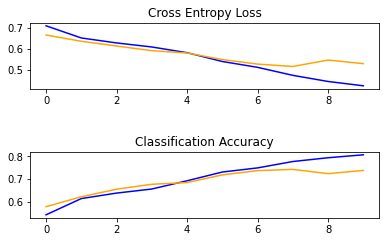

In [46]:
model_3_histroy, model_3 = run_test_harness()

### Conclusion

The results are summarized below: <br>
    <br>
VGG 1: 70.60% <br>
VGG 2: 75.73% <br>
VGG 3: 73.77% <br>

I am surprised that VGG 2 performed the best, as I was expecting a consistent upward trend of model accuracy.

In [55]:
# create submission
datagen = ImageDataGenerator(rescale=1.0/255.0)
test = 'test/'
test = datagen.flow_from_directory('.', classes=['test'], batch_size=64, target_size=(200, 200))

Found 12500 images belonging to 1 classes.


In [48]:
preds3 = model_3.predict(x=test, steps=len(test), verbose=0)

In [52]:
predict_3 = pd.DataFrame(preds3)
predict_3.index.rename("id", inplace=True)
predict_3.index += 1
predict_3.rename(columns={0: 'label'}, inplace=True)

In [53]:
predict_3.head()

,label
id,
1,0.300159
2,0.317467
3,0.428850
4,0.880748
5,0.695579


In [54]:
predict_3.to_csv('model3.csv')

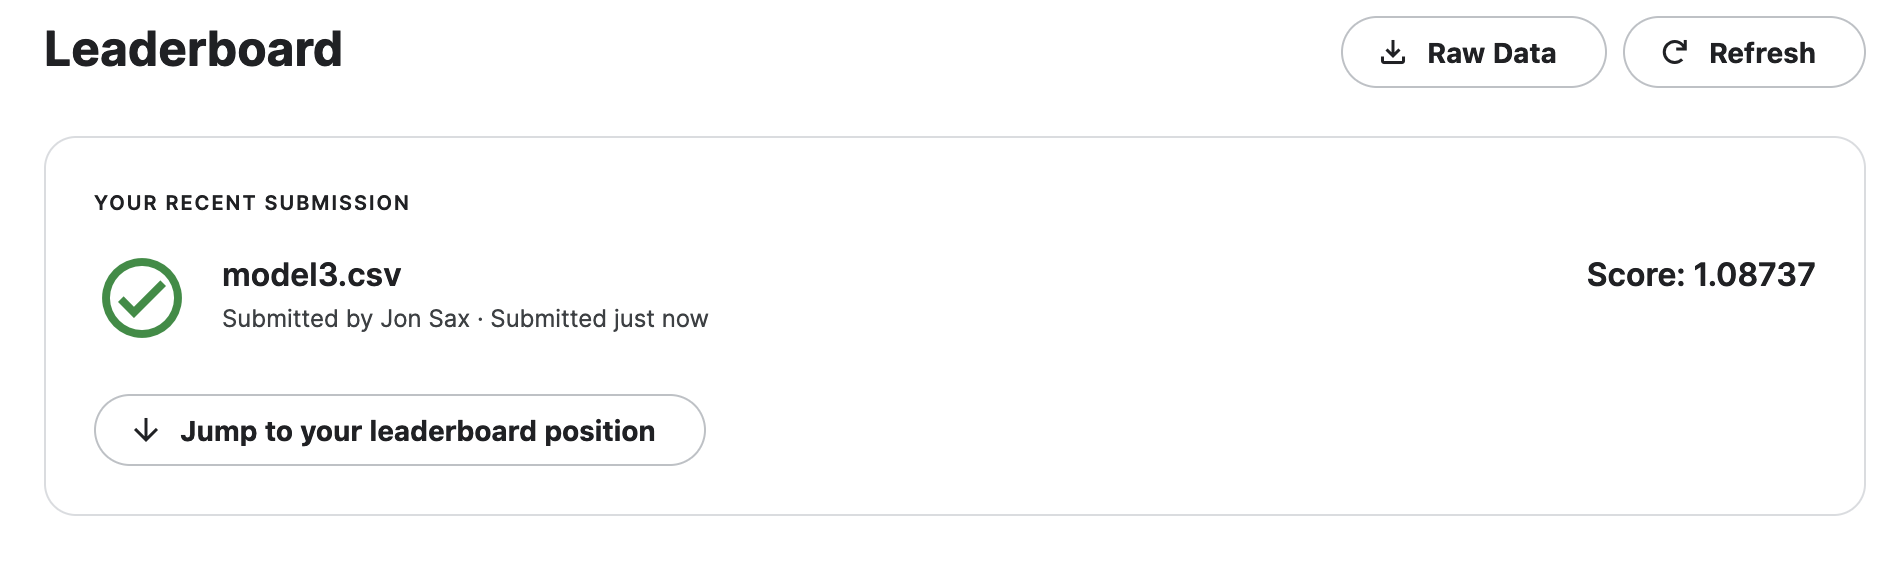